In [23]:
%matplotlib inline

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import pandas as pd
import numpy as np
import urllib
import requests

import matplotlib.pyplot as plt

from pandas.core.frame import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

import dataset

In [376]:
pd.set_option('display.max_columns', 200)

In [354]:
%%time
kdd = dataset.KDD1999()

CPU times: user 16.3 s, sys: 2.83 s, total: 19.1 s
Wall time: 6.87 s


In [355]:
kdd.df.shape

(494021, 42)

In [283]:
%%time
kdd.report_labels()

CPU times: user 339 ms, sys: 44.6 ms, total: 383 ms
Wall time: 384 ms


,attacks,prevalence,prevalence (overall),records
label,,,,
smurf.,280790,0.742697,0.568377,378068
neptune.,107201,0.524264,0.216997,204479
back.,2203,0.022145,0.004459,99481
satan.,1589,0.016072,0.003216,98867
ipsweep.,1247,0.012657,0.002524,98525
portsweep.,1040,0.010578,0.002105,98318
warezclient.,1020,0.010377,0.002065,98298
teardrop.,979,0.009964,0.001982,98257
pod.,264,0.002707,0.000534,97542


In [388]:
%%time
df_baseline_oracle = kdd.report_baseline_oracle()

CPU times: user 22.2 s, sys: 6.53 s, total: 28.7 s
Wall time: 18.1 s


In [389]:
df_baseline_oracle

,baseline_random_FN,baseline_random_FP,baseline_random_f1,baseline_random_precision,baseline_random_recall,baseline_unsupervised_FN,baseline_unsupervised_FP,baseline_unsupervised_f1,baseline_unsupervised_precision,baseline_unsupervised_recall,oracle_FN,oracle_FP,oracle_average precision,oracle_f1,oracle_precision,oracle_recall,oracle_roc auc,oracle_train time (s),prevalence
label,,,,,,,,,,,,,,,,,,,
smurf.,7269.5,7216.0,0.741785,0.743077,0.741105,19212,9728,0.379955,0.476849,0.315788,0,0,1.000000,1.000000,1.0,1.000000,1.000000,0.752051,0.742698
neptune.,5119.5,5100.5,0.523417,0.523515,0.522435,6399,6310,0.404759,0.406453,0.403078,1,0,1.000000,0.999953,1.0,0.999907,1.000000,0.484131,0.524266
back.,214.5,219.0,0.025331,0.025673,0.025000,186,178,0.157407,0.160377,0.154545,0,0,1.000000,1.000000,1.0,1.000000,1.000000,0.164407,0.022153
satan.,157.5,160.0,0.009401,0.009380,0.009434,19,24,0.866873,0.853659,0.880503,0,0,1.000000,1.000000,1.0,1.000000,1.000000,0.255038,0.016070
ipsweep.,124.0,119.5,0.008152,0.008323,0.008000,89,79,0.300000,0.313043,0.288000,0,0,1.000000,1.000000,1.0,1.000000,1.000000,0.143429,0.012649
portsweep.,103.0,109.5,0.009905,0.010221,0.009615,47,24,0.616216,0.703704,0.548077,1,0,0.990486,0.995169,1.0,0.990385,0.995188,0.160366,0.010578
warezclient.,101.0,96.0,0.010283,0.010878,0.009804,96,94,0.059406,0.060000,0.058824,2,0,0.999534,0.990099,1.0,0.980392,0.999997,0.238229,0.010377
teardrop.,97.0,96.0,0.009877,0.009570,0.010204,74,87,0.229665,0.216216,0.244898,0,0,1.000000,1.000000,1.0,1.000000,1.000000,0.136617,0.009961
pod.,26.0,27.0,0.000000,0.000000,0.000000,13,21,0.433333,0.382353,0.500000,1,0,1.000000,0.980392,1.0,0.961538,1.000000,0.153835,0.002717


In [392]:
df_baseline_oracle.mean().round(2)

baseline_random_FN                 1323.50
baseline_random_FP                 1316.65
baseline_random_f1                    0.13
baseline_random_precision             0.13
baseline_random_recall                0.13
baseline_unsupervised_FN           2615.80
baseline_unsupervised_FP           1656.20
baseline_unsupervised_f1              0.34
baseline_unsupervised_precision       0.36
baseline_unsupervised_recall          0.34
oracle_FN                             0.50
oracle_FP                             0.00
oracle_average precision              1.00
oracle_f1                             1.00
oracle_precision                      1.00
oracle_recall                         0.99
oracle_roc auc                        1.00
oracle_train time (s)                 0.26
prevalence                            0.14
dtype: float64

In [394]:
df_baseline_oracle.std().round(2)

baseline_random_FN                 2617.38
baseline_random_FP                 2600.63
baseline_random_f1                    0.27
baseline_random_precision             0.27
baseline_random_recall                0.27
baseline_unsupervised_FN           6161.57
baseline_unsupervised_FP           3449.26
baseline_unsupervised_f1              0.26
baseline_unsupervised_precision       0.27
baseline_unsupervised_recall          0.26
oracle_FN                             0.71
oracle_FP                             0.00
oracle_average precision              0.00
oracle_f1                             0.01
oracle_precision                      0.00
oracle_recall                         0.01
oracle_roc auc                        0.00
oracle_train time (s)                 0.20
prevalence                            0.27
dtype: float64

In [369]:
df_active_learning_report = kdd.report_active_learning()

Label: smurf., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
Loaded from cache
Label: smurf., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: smurf., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: smurf., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: smurf., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: smurf., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: neptune., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: neptune., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: neptune., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: neptune., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: neptune., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: neptune., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: back., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: back., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: back., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: back., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: back., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: back., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: satan., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: satan., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: satan., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: satan., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: satan., learner: LogisticRegression, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: satan., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: ipsweep., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: ipsweep., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: ipsweep., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: ipsweep., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: ipsweep., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: ipsweep., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: portsweep., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: portsweep., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: portsweep., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: portsweep., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to 

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

Label: portsweep., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: P

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to 

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs f

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: P

Label: portsweep., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to 

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and

Label: warezclient., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: warezclient., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: warezclient., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: warezclient., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: warezclient., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: warezclient., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: teardrop., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: teardrop., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: teardrop., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: teardrop., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: teardrop., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: teardrop., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: pod., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: pod., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1
round 26
round 51
round 76
Label: pod., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: pod., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: pod., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: pod., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: nmap., learner: RandomForestClassifier, sampling strategy: uncertainty_sampling
round 1
round 26
round 51
round 76
Label: nmap., learner: RandomForestClassifier, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: P

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: P

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: P

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Label: nmap., learner: RandomForestClassifier, sampling strategy: entropy_sampling
round 1
round 26
round 51
round 76
Label: nmap., learner: LogisticRegression, sampling strategy: uncertainty_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: nmap., learner: LogisticRegression, sampling strategy: random_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

Label: nmap., learner: LogisticRegression, sampling strategy: entropy_sampling
round 1


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 26


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 51


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

round 76


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

In [379]:
(df_active_learning_report
 .groupby(['learner', 'sampling strategy'])
 .agg([np.mean, np.std])
).round(2)

initial_FN        initial_FP  \
                                                  mean    std       mean   
learner                sampling strategy                                   
LogisticRegression     entropy_sampling           20.2  29.86       14.8   
                       random_sampling            20.2  29.86       14.8   
                       uncertainty_sampling       20.2  29.86       14.8   
RandomForestClassifier entropy_sampling            6.9   6.49        0.6   
                       random_sampling             8.6   5.99        0.2   
                       uncertainty_sampling        9.7   7.02        2.9   

                                                   initial_average precision  \
                                               std                      mean   
learner                sampling strategy                                       
LogisticRegression     entropy_sampling      17.18                      0.72   
                       random_sampling       17.18                      0.72   
                       uncertainty_sampling  17.18                      0.72   
RandomForestClassifier entropy_sampling       1.26                      0.96   
                       random_sampling        0.63                      0.96   
                       uncertainty_sampling   7.82                      0.96   

                                                  initial_f1        \
                                              std       mean   std   
learner                sampling strategy                             
LogisticRegression     entropy_sampling      0.36       0.76  0.32   
                       random_sampling       0.36       0.76  0.32   
                       uncertainty_sampling  0.36       0.76  0.32   
RandomForestClassifier entropy_sampling      0.06       0.92  0.13   
                       random_sampling       0.09       0.90  0.14   
                       uncertainty_sampling  0.08       0.91  0.11   

                                            initial_precision        \
                                                         mean   std   
learner                sampling strategy                              
LogisticRegression     entropy_sampling                  0.76  0.33   
                       random_sampling                   0.76  0.33   
                       uncertainty_sampling              0.76  0.33   
RandomForestClassifier entropy_sampling                  0.99  0.01   
                       random_sampling                   1.00  0.01   
                       uncertainty_sampling              0.98  0.05   

                                            initial_recall        \
                                                      mean   std   
learner                sampling strategy                           
LogisticRegression     entropy_sampling               0.76  0.31   
                       random_sampling                0.76  0.31   
                       uncertainty_sampling           0.76  0.31   
RandomForestClassifier entropy_sampling               0.87  0.20   
                       random_sampling                0.85  0.20   
                       uncertainty_sampling           0.88  0.18   

                                            initial_roc auc        \
                                                       mean   std   
learner                sampling strategy                            
LogisticRegression     entropy_sampling                0.97  0.04   
                       random_sampling                 0.97  0.04   
                       uncertainty_sampling            0.97  0.04   
RandomForestClassifier entropy_sampling                0.98  0.03   
                       random_sampling                 0.99  0.03   
                       uncertainty_sampling            0.98  0.03   

                                            sample_100_FN       sample_100_FP  \
                                                   

In [ ]:
df_active_learning_report.sam

In [387]:
x = {}
for learner_name in ['RandomForestClassifier', 'LogisticRegression']:
    for sampling_strategy_name in ['uncertainty_sampling', 'random_sampling', 'entropy_sampling']:
        concat = []
        for label in kdd.features:
            label_clean = label.replace('.', '')
            file_path = f'{label_clean}_{learner_name}_{sampling_strategy_name}'
            file_path_csv = f'{file_path}.csv'
            df = pd.read_csv(file_path_csv)
            concat += list(df['query time (s)'])
            
        xs = pd.Series(concat)
        mean = round(xs.mean(), 2)
        std = round(xs.std(), 2)
        x[(learner_name, sampling_strategy_name)] = {f'{mean}±{std}'}
        
x

{('RandomForestClassifier', 'uncertainty_sampling'): {'0.16±0.06'},
 ('RandomForestClassifier', 'random_sampling'): {'0.09±0.07'},
 ('RandomForestClassifier', 'entropy_sampling'): {'0.12±0.08'},
 ('LogisticRegression', 'uncertainty_sampling'): {'0.1±0.08'},
 ('LogisticRegression', 'random_sampling'): {'0.09±0.08'},
 ('LogisticRegression', 'entropy_sampling'): {'0.08±0.08'}}

In [413]:
d.shape

(202, 6)

In [421]:
def plot_it(file_path):
    d = pd.read_csv(file_path).iloc[-101:].reset_index(drop=True)
    d.f1.plot()

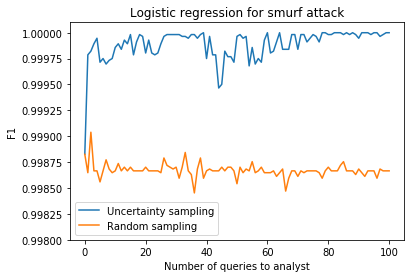

In [453]:
plot_it('smurf_LogisticRegression_uncertainty_sampling.csv')
plot_it('smurf_LogisticRegression_random_sampling.csv')
plt.ylim([0.9980, 1.0001])
plt.ylabel('F1')
plt.xlabel('Number of queries to analyst')
plt.title('Logistic regression for smurf attack')
plt.legend(['Uncertainty sampling', 'Random sampling'])

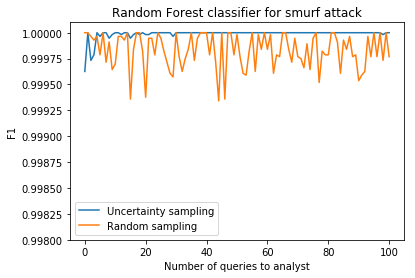

In [456]:
plot_it('smurf_RandomForestClassifier_uncertainty_sampling.csv')
plot_it('smurf_RandomForestClassifier_random_sampling.csv')
plt.ylim([0.9980, 1.0001])
plt.ylabel('F1')
plt.xlabel('Number of queries to analyst')
plt.title('Random Forest classifier for smurf attack')
plt.legend(['Uncertainty sampling', 'Random sampling'])

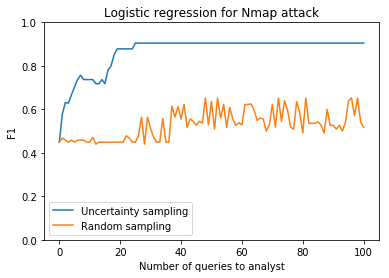

In [458]:
plot_it('nmap_LogisticRegression_uncertainty_sampling.csv')
plot_it('nmap_LogisticRegression_random_sampling.csv')
plt.ylim([0, 1])
plt.ylabel('F1')
plt.xlabel('Number of queries to analyst')
plt.title('Logistic regression for Nmap attack')
plt.legend(['Uncertainty sampling', 'Random sampling'])

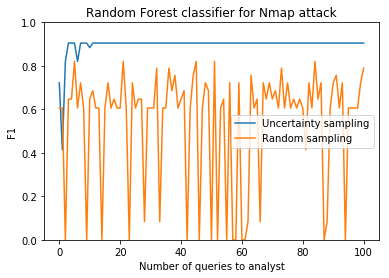

In [459]:
plot_it('nmap_RandomForestClassifier_entropy_sampling.csv')
plot_it('nmap_RandomForestClassifier_random_sampling.csv')
plt.ylim([0, 1])
plt.ylabel('F1')
plt.xlabel('Number of queries to analyst')
plt.title('Random Forest classifier for Nmap attack')
plt.legend(['Uncertainty sampling', 'Random sampling'])